# Surrogate PLV Testing

Test whether observed phase-locking is statistically significant
using circular time-shifting surrogates. The median rotation method
(Banellis et al., 2025) creates a null distribution by circularly
shifting the reference signal, preserving autocorrelation while
destroying the true phase relationship.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## Create Coupled and Uncoupled Signals

We simulate 10 "voxels": 5 coupled to a reference EGG phase
(with increasing noise), and 5 with random phases.

In [2]:
rng = np.random.default_rng(42)
n = 400
t = np.arange(n)

# Frequency-modulated EGG phase (realistic)
freq_jitter = 0.05 + 0.005 * np.sin(2 * np.pi * 0.003 * t)
egg_phase = np.angle(np.exp(1j * np.cumsum(2 * np.pi * freq_jitter)))

# 5 coupled voxels + 5 random voxels
coupled = np.column_stack([egg_phase + off + 0.3 * rng.standard_normal(n) for off in np.linspace(0.1, 1.0, 5)])
uncoupled = rng.uniform(-np.pi, np.pi, (n, 5))
bold_phases = np.column_stack([coupled, uncoupled])

plv_emp = gp.phase_locking_value(bold_phases, egg_phase)
print("Empirical PLV:")
print(f"  Coupled: {plv_emp[:5].round(4)}")
print(f"  Random:  {plv_emp[5:].round(4)}")

Empirical PLV:
  Coupled: [0.9601 0.9547 0.9572 0.9515 0.9563]
  Random:  [0.0761 0.0215 0.0185 0.0192 0.0492]


## Median Surrogate PLV

The default `stat="median"` returns the median PLV across all
circular shifts — a robust summary of the null distribution.

In [3]:
surr = gp.surrogate_plv(bold_phases, egg_phase, n_surrogates=200, seed=42)
print("Surrogate PLV (median):")
print(f"  Coupled: {surr[:5].round(4)}")
print(f"  Random:  {surr[5:].round(4)}")

z = gp.coupling_zscore(plv_emp, surr)
print("\nCoupling z-score (empirical - surrogate):")
print(f"  Coupled: {z[:5].round(4)}")
print(f"  Random:  {z[5:].round(4)}")

Surrogate PLV (median):
  Coupled: [0.2584 0.2626 0.2618 0.2733 0.265 ]
  Random:  [0.0347 0.0486 0.0327 0.0442 0.0346]

Coupling z-score (empirical - surrogate):
  Coupled: [0.7017 0.692  0.6954 0.6781 0.6913]
  Random:  [ 0.0414 -0.0271 -0.0142 -0.025   0.0146]


## Full Surrogate Distribution

Use `stat="all"` to get the complete null distribution. This
allows proper z-scoring and permutation-based p-values.

In [4]:
# Full distribution for one coupled voxel
surr_all = gp.surrogate_plv(
    bold_phases[:, 0:1],
    egg_phase,
    n_surrogates=200,
    stat="all",
    seed=42,
)
print(f"Surrogate distribution: {surr_all.shape}")
print(f"  Mean: {surr_all.mean():.4f}, Std: {surr_all.std():.4f}")

z_proper = gp.coupling_zscore(plv_emp[0], surr_all.squeeze())
print(f"Empirical PLV: {plv_emp[0]:.4f}")
print(f"Z-score (proper): {z_proper:.4f}")

p_perm = np.mean(surr_all.squeeze() >= plv_emp[0])
print(f"Permutation p-value: {p_perm:.4f}")

Surrogate distribution: (200, 1)
  Mean: 0.2575, Std: 0.1482
Empirical PLV: 0.9601
Z-score (proper): 4.7287
Permutation p-value: 0.0000


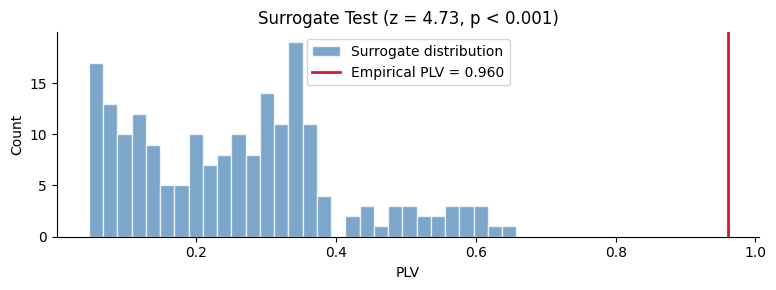

In [5]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(surr_all.squeeze(), bins=30, alpha=0.7, color="steelblue", edgecolor="white", label="Surrogate distribution")
ax.axvline(plv_emp[0], color="crimson", linewidth=2, label=f"Empirical PLV = {plv_emp[0]:.3f}")
ax.set_xlabel("PLV")
ax.set_ylabel("Count")
ax.set_title(f"Surrogate Test (z = {z_proper:.2f}, p < 0.001)")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
plt.show()

**See also:** [PLV Computation](plv_computation.ipynb),
[Circular Statistics](circular_statistics.ipynb),
[Coupling Tutorial](../tutorials/gastric_brain_coupling.ipynb)